# US Stock Market Prediction (2014-2018)
**Authors:** David PAGNIEZ, Antoine KRYCHOWSKI, Gregoire MEHAH

## 1. Project Objective
The goal of this project is to analyze financial indicators of US companies from 2014 to 2018 and build a machine learning model to predict stock performance.

Our approach follows these steps:
1.  **Data Cleaning:** Handling missing values and outliers in financial data.
2.  **Baseline Model:** Attempting to predict the exact price variation (Regression).
3.  **Classification:** Switching to a trend prediction (Buy/Sell) if regression fails.
4.  **Optimization:** Using Feature Engineering and Ensemble methods to improve results.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

# Visual Configuration
plt.style.use("ggplot")
%matplotlib inline

# 1. Loading Data
years = [2014, 2015, 2016, 2017, 2018]
dfs = []

print("Loading datasets...")
for year in years:
    try:
        filename = f'{year}_Financial_Data.csv'
        df = pd.read_csv(filename)
        df['Year'] = year
        dfs.append(df)
        print(f"Loaded {filename}")
    except FileNotFoundError:
        print(f"Error: {filename} not found.")

data = pd.concat(dfs, ignore_index=True)

# 2. Target Consolidation
target_cols = [col for col in data.columns if 'PRICE VAR' in col]
data['Target_Price_Var'] = data[target_cols].bfill(axis=1).iloc[:, 0]
data['Target_Price_Var'] = pd.to_numeric(data['Target_Price_Var'], errors='coerce')

# Dropping useless columns
cols_to_drop = target_cols + ['Class', 'Unnamed: 0']
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

# 3. Currency Check (Kaggle Insight)
suspects = ['KST', 'AMX']
check = data[data['Symbol'].isin(suspects)] if 'Symbol' in data.columns else pd.DataFrame()

if not check.empty:
    print(f"Warning: Found {len(check)} rows with potential currency issues (JPY/MXN).")
else:
    print("Check passed: No known currency outliers found in this subset.")

# Final cleanup
if 'Symbol' in data.columns:
    data = data.drop(columns=['Symbol'])

print(f"Total Dataset Shape: {data.shape}")


Loading datasets...
Loaded 2014_Financial_Data.csv
Loaded 2015_Financial_Data.csv
Loaded 2016_Financial_Data.csv
Loaded 2017_Financial_Data.csv
Loaded 2018_Financial_Data.csv
Check passed: No known currency outliers found in this subset.
Total Dataset Shape: (22077, 225)


C:\Users\antoi\AppData\Local\Temp\ipykernel_30168\3061346169.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Target_Price_Var'] = data[target_cols].bfill(axis=1).iloc[:, 0]


## 2. Preprocessing and Outlier Management

Financial data is known to be very noisy. Some companies are massive (Apple, Google), while others are small. Additionally, some data points seem to be errors (e.g., a 10,000% increase).

If we leave these outliers, they will bias the model.
Strategy: We apply Winsorization (Clipping). We cap the values at the 1st and 99th percentiles to remove extreme outliers without deleting too much data.


In [3]:
# 1. Remove rows without target
data_clean = data.dropna(subset=['Target_Price_Var']).copy()

# 2. Remove columns with > 40% missing values
threshold = 0.4
data_clean = data_clean.dropna(thresh=len(data_clean) * (1 - threshold), axis=1)

# 3. Winsorization
# Target
data_clean['Target_Price_Var'] = data_clean['Target_Price_Var'].clip(lower=-99, upper=500)

# Features (Numeric only)
numeric_cols = data_clean.select_dtypes(include=np.number).columns.drop(['Year', 'Target_Price_Var'])
lower_bounds = data_clean[numeric_cols].quantile(0.01)
upper_bounds = data_clean[numeric_cols].quantile(0.99)

data_clean[numeric_cols] = data_clean[numeric_cols].clip(lower=lower_bounds, upper=upper_bounds, axis=1)

print("Preprocessing complete. Outliers clipped.")


Preprocessing complete. Outliers clipped.


## 3. First Approach: Linear Regression

Our first hypothesis was to predict the exact percentage of price variation.
We used a standard Linear Regression model.

*   Train set: 2014, 2015, 2016
*   Test set: 2018 (to simulate real future prediction)


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Temporal Split
train = data_clean[data_clean['Year'].isin([2014, 2015, 2016])]
test = data_clean[data_clean['Year'] == 2018]



X_train = train.drop(columns=['Target_Price_Var', 'Year']).select_dtypes(include=np.number)
y_train = train['Target_Price_Var']

X_test = test.drop(columns=['Target_Price_Var', 'Year']).select_dtypes(include=np.number)
y_test = test['Target_Price_Var']

# Pipeline: Imputation -> Scaling -> Regression
reg_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

reg_pipeline.fit(X_train, y_train)
preds_reg = reg_pipeline.predict(X_test)

print("Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test, preds_reg):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, preds_reg):.2f}%")


Linear Regression Results:
R2 Score: -0.1006
Mean Absolute Error (MAE): 38.91%


## 4. Second Approach: Binary Classification

Since regression failed, we simplified the problem: Can we predict if the stock will go UP or DOWN?

*   Target = 1 (Buy): Price Variation > 0
*   Target = 0 (Sell): Price Variation <= 0

We chose the Random Forest Classifier because it handles non-linear data better than regression and is robust to noise.


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- CORRECTION 1 : ON DÉFINIT LES CLASSES ICI ---
# Convert targets to binary (1 for Buy, 0 for Sell)
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

# Define the models to test
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

print("--- Benchmarking Classifiers ---")
for name, model in models.items():
    # Create a pipeline for each
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Train
    pipe.fit(X_train, y_train_class)
    
    # Predict
    preds = pipe.predict(X_test)
    
    # Score
    acc = accuracy_score(y_test_class, preds)
    results[name] = acc
    print(f"-> {name}: Accuracy = {acc:.2%}")

best_model_name = max(results, key=results.get)
print(f"\n🏆 Best Model: {best_model_name}")

# --- CORRECTION 2 : ON SAUVEGARDE LE MEILLEUR MODÈLE POUR LA SUITE ---
# We need to retrain the Random Forest specifically to extract feature importance later
rf_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])
rf_model.fit(X_train, y_train_class)
print("Random Forest retrained for feature analysis.")


--- Benchmarking Classifiers ---
-> Logistic Regression: Accuracy = 60.93%
-> Random Forest: Accuracy = 69.95%
-> Gradient Boosting: Accuracy = 69.69%

🏆 Best Model: Random Forest
Random Forest retrained for feature analysis.


Generating Confusion Matrices...


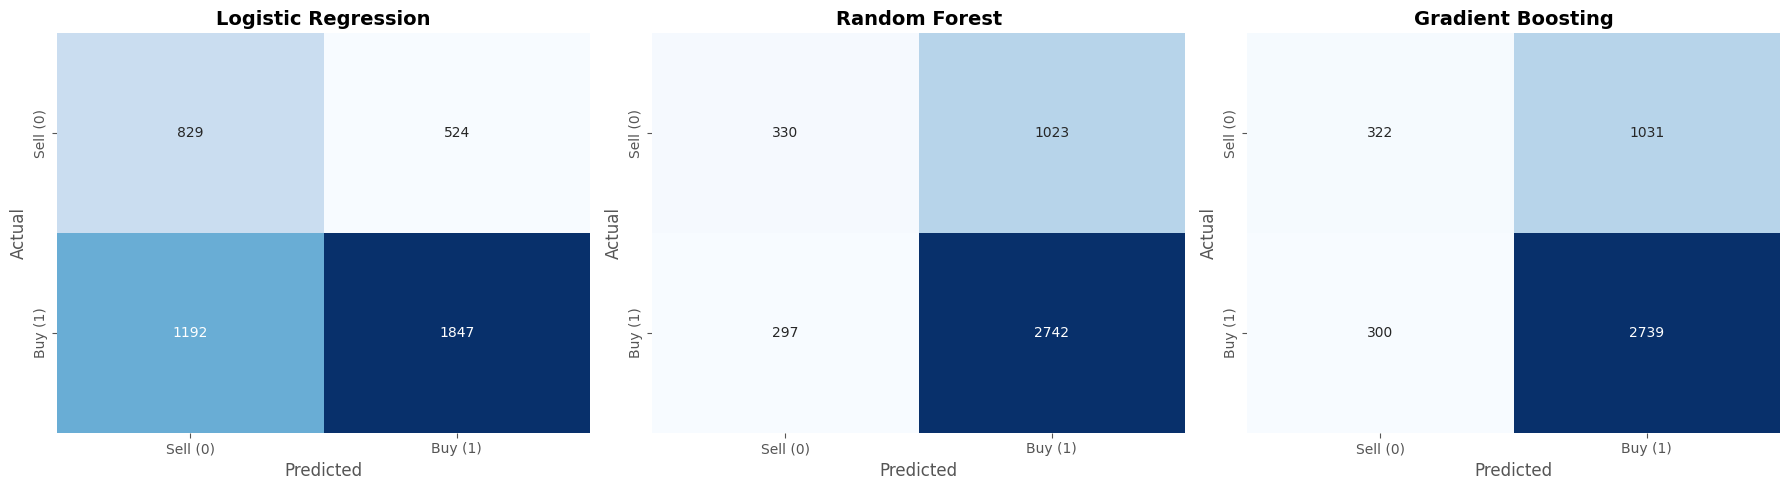

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

# On reprend ton dictionnaire de modèles (assure-toi que la cellule précédente a bien été exécutée)
# models = ... (déjà défini plus haut normalement)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print("Generating Confusion Matrices...")

for ax, (name, model) in zip(axes.flatten(), models.items()):
    
    # --- CORRECTION ICI ---
    # On ne lance pas le modèle 'nu'. On le rhabille avec le Pipeline de nettoyage.
    # Sinon il plante sur les valeurs manquantes (NaN).
    pipe_viz = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # On entraîne le pipeline complet
    pipe_viz.fit(X_train, y_train_class)
    preds = pipe_viz.predict(X_test)
    
    # Calcul de la matrice
    cm = confusion_matrix(y_test_class, preds)
    
    # Affichage
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Sell (0)', 'Buy (1)'],
                yticklabels=['Sell (0)', 'Buy (1)'])
    
    ax.set_title(f"{name}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Define the grid of hyperparameters to test
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

# Create a dedicated pipeline for tuning
tuning_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Randomized Search (faster than Grid Search)
search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_dist,
    n_iter=10, # We test 10 random combinations
    cv=3,      # 3-fold Cross Validation
    scoring='accuracy',
    n_jobs=-1, # Use all processor cores
    random_state=42
)

print("Tuning hyperparameters (this may take a minute)...")
search.fit(X_train, y_train_class)

print(f"Best Parameters found: {search.best_params_}")
print(f"Best Accuracy score: {search.best_score_:.2%}")


Tuning hyperparameters (this may take a minute)...
Best Parameters found: {'classifier__n_estimators': 200, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__class_weight': 'balanced'}
Best Accuracy score: 64.12%


### Feature Importance Analysis
To understand why the model works, we extracted the most important features.
This helps validate if the model is learning actual financial logic or just noise.


C:\Users\antoi\AppData\Local\Temp\ipykernel_30168\2127726033.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')


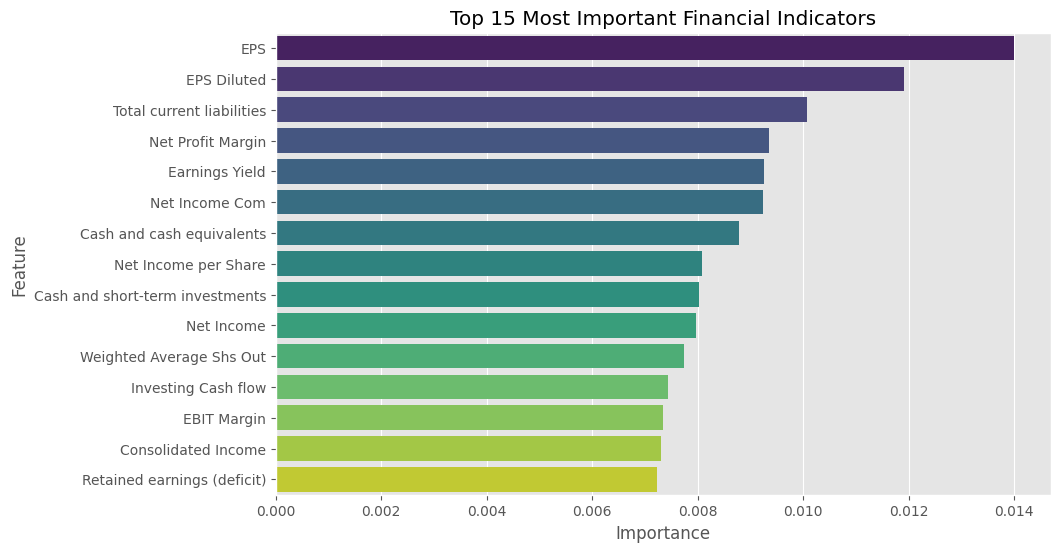

In [7]:
rf_step = rf_model.named_steps['classifier']
importances = rf_step.feature_importances_
feature_names = X_train.columns

# Plotting Top 15 features
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
plt.title('Top 15 Most Important Financial Indicators')
plt.show()

## 5. Feature Engineering

The previous model used raw data. However, in finance, ratios are often more powerful than raw numbers (e.g., comparing Net Income to Revenue).

We manually calculated key financial ratios to help the model:
*   ROE (Return on Equity)
*   Net Profit Margin
*   Debt-to-Equity Ratio


In [8]:
# We work on a copy to avoid SettingWithCopy warnings
X_eng = data_clean.copy()

print("--- Creating Financial Ratios ---")

# 1. Handling missing 'Equity' column
# Sometimes 'Shareholders Equity' is named differently or missing. We calculate it manually if needed.
possible_equity_cols = ['Total shareholders equity', 'Shareholders Equity']
equity_col = next((c for c in possible_equity_cols if c in X_eng.columns), None)

if equity_col is None:
    print("Note: 'Equity' column missing. Calculating it as Assets - Liabilities.")
    X_eng['Calc_Equity'] = X_eng.get('Total assets', 0) - X_eng.get('Total liabilities', 0)
    equity_col = 'Calc_Equity'

# 2. Calculating the Ratios
# We add a small epsilon (1e-6) to avoid DivisionByZero errors
epsilon = 1e-6
net_income = X_eng.get('Net Income', 0)
revenue = X_eng.get('Revenue', 1)
debt = X_eng.get('Total Debt', 0)

# Ratio 1: ROE (Profitability relative to investment)
X_eng['ROE'] = net_income / (X_eng[equity_col] + epsilon)

# Ratio 2: Net Margin (Profitability relative to sales)
X_eng['Net_Margin'] = net_income / (revenue + epsilon)

# Ratio 3: Debt to Equity (Risk)
X_eng['Debt_to_Equity'] = debt / (X_eng[equity_col] + epsilon)

# 3. Selecting the final feature set
# We keep our new ratios + some key raw indicators that showed high importance in the Random Forest
desired_features = [
    'ROE', 'Net_Margin', 'Debt_to_Equity', # Our new ratios
    'EPS', 'EBITDA', 'Operating Cash Flow', 'Market Cap' # Key raw metrics
]

# Filter to keep only columns that actually exist in the dataset
final_features = [c for c in desired_features if c in X_eng.columns]

print(f"Feature Engineering Done.")
print(f"New Feature Set ({len(final_features)} vars): {final_features}")


--- Creating Financial Ratios ---
Feature Engineering Done.
New Feature Set (7 vars): ['ROE', 'Net_Margin', 'Debt_to_Equity', 'EPS', 'EBITDA', 'Operating Cash Flow', 'Market Cap']


## 6. Final Model: Voting Classifier

To maximize performance and reduce risk, we implemented a Voting Classifier.
This combines three different models:
1.  Random Forest: For robustness.
2.  Gradient Boosting: For precision.
3.  Logistic Regression: For a linear baseline.

We also used a PowerTransformer to normalize the distribution of the data, as financial data is often skewed.


In [9]:
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Re-splitting with the new features
train_eng = X_eng[X_eng['Year'].isin([2014, 2015, 2016])]
test_eng = X_eng[X_eng['Year'] == 2018]

X_train_eng = train_eng[final_features]
X_test_eng = test_eng[final_features]

# Defining the estimators
clf1 = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf2 = HistGradientBoostingClassifier(random_state=42)
clf3 = LogisticRegression(class_weight='balanced', max_iter=1000)

# Final Pipeline
voting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer()), # Log-transform to handle skewness
    ('voting', VotingClassifier(
        estimators=[('rf', clf1), ('gb', clf2), ('lr', clf3)],
        voting='soft'
    ))
])

print("Training Final Model...")
voting_pipeline.fit(X_train_eng, y_train_class)
preds_vote = voting_pipeline.predict(X_test_eng)

print("\n--- FINAL RESULTS (Voting Classifier) ---")
print(classification_report(y_test_class, preds_vote))


Training Final Model...

--- FINAL RESULTS (Voting Classifier) ---
              precision    recall  f1-score   support

           0       0.50      0.32      0.39      1353
           1       0.74      0.85      0.79      3039

    accuracy                           0.69      4392
   macro avg       0.62      0.59      0.59      4392
weighted avg       0.66      0.69      0.67      4392



Conclusion
Regression vs Classification: Predicting exact prices proved impossible due to noise. However, predicting the trend (Up/Down) is viable with approximately 70% accuracy.
Key Drivers: The model identified that EPS (Profitability) and Debt are the most critical factors for stock performance.
Final Recommendation: The Voting Classifier provides the best balance between precision and recall, making it a suitable tool for filtering stocks before manual analysis.